#**M5 New Taipei City Real Estate Valuation Dataset**




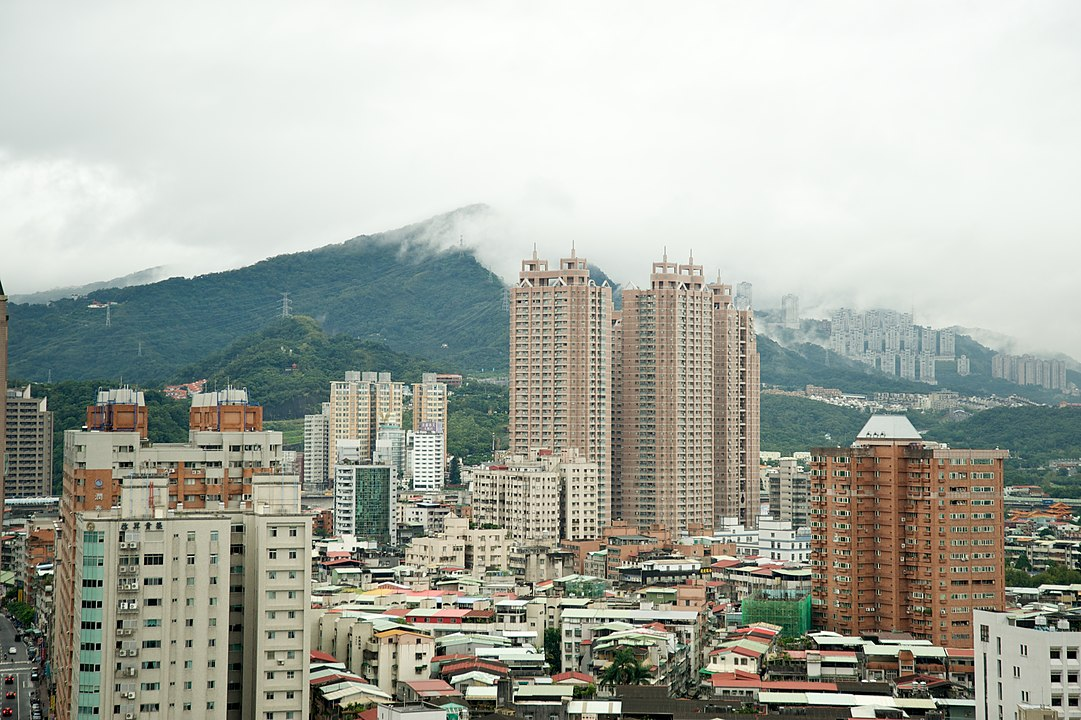

By Fred Hsu on en.wikipedia - Photo taken and uploaded by user, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=9600721

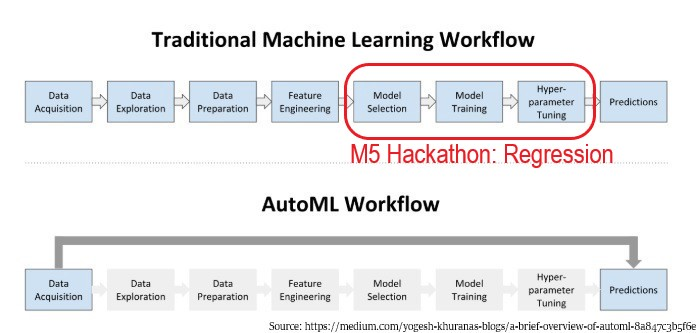

#**Table of Contents**
* Executive Summary (BLUF)
* Business Problem
* Metrics
* Libraries
* Data
* Data Preprocessing
* Holdout Sample & Scaling
* Feature Importance
* Base Learners on Holdout Sample
* Ensembles & Deep Learning on Holdout Sample
* Learning Curves (Cross Validation)
* Winner Winner Chicken Dinner
* Keras Model Investigated
* Conclusion


#**Executive Summary (BLUF)** 
Ensembles do the best on a holdout samnple. A cross-validated deep learning model yields the best performance results overall, with an MSE of around 21 and a worst case error in the 85% range. The model is not deemed suitable for deployment even as a decision aid (cobot).

#**Business Problem**
Predict the price per ping of properties on the market in New Taipei City, taking care to ensure that no property is under- or over-valued by more than 20% (assuming Tukey Rule price/ping outliers have been deleted).

#**Metrics**
MSE will be the primary aggregate performance metric as large errors are more important than smalletr prediction errors. MAE and $R^2$ will be reported as supplementary metrics. Over- and underprediction are deemed equally important, and the business problem calls for a ceiling on over- and underprediction of 20%. Accordingly, the worst instance prediction error will be presented. 

#**Libraries**


In [ ]:
# Basic libraries
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import unique
from numpy import where
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import pyplot
import scipy.stats as ss
import math

In [ ]:
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
# Keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error

#**Data**
The following is adaptedfrom https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set

The market historical data set of real estate valuation were collected from Sindian Dist., New Taipei City, Taiwan. 

Original attribute information:

The predictors/deatires are as follows:
- X1=the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)
- X2=the house age (unit: year)
- X3=the distance to the nearest MRT station (unit: meter)
- X4=the number of convenience stores in the living circle on foot (integer)
- X5=the geographic coordinate, latitude. (unit: degree)
- X6=the geographic coordinate, longitude. (unit: degree)

The target is as follows:
Y= house price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared)

In [ ]:
# Update openpyxl
!pip install openpyxl==3.0.5


     |████████████████████████████████| 242 kB 13.2 MB/s eta 0:00:01
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.9
    Uninstalling openpyxl-3.0.9:
      Successfully uninstalled openpyxl-3.0.9


In [ ]:
# Read data from UCI Machine Learning Repo
file_ = "https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx"   
df = pd.DataFrame(pd.read_excel(file_)) # read in csv file

In [ ]:
# Head of df
df.head(10)

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1
5,6,2012.666667,7.1,2175.03000,3,24.96305,121.51254,32.1
6,7,2012.666667,34.5,623.47310,7,24.97933,121.53642,40.3
7,8,2013.416667,20.3,287.60250,6,24.98042,121.54228,46.7
8,9,2013.500000,31.7,5512.03800,1,24.95095,121.48458,18.8
9,10,2013.416667,17.9,1783.18000,3,24.96731,121.51486,22.1


#**Data Preprocessing**

In [ ]:
# Drop the index column (Column 0, "No")
if 'No' in df.columns:
  df = df.drop(["No"], axis = 1)

# The column names are verbose, so rename them (optional)
df.rename(columns = {"X1 transaction date": "X1_Date", "X2 house age": "X2_Age", "X3 distance to the nearest MRT station": "X3_MRT", "X4 number of convenience stores": "X4_Stores", "X5 latitude": "X5_Lat", "X6 longitude": "X6_Long", "Y house price of unit area": "Y_Price"},inplace = True)

# Examine the data using df.head() or df.tail()
print("HEAD of df\n", df.head()) 

HEAD of df
        X1_Date  X2_Age     X3_MRT  X4_Stores    X5_Lat    X6_Long  Y_Price
0  2012.916667    32.0   84.87882         10  24.98298  121.54024     37.9
1  2012.916667    19.5  306.59470          9  24.98034  121.53951     42.2
2  2013.583333    13.3  561.98450          5  24.98746  121.54391     47.3
3  2013.500000    13.3  561.98450          5  24.98746  121.54391     54.8
4  2012.833333     5.0  390.56840          5  24.97937  121.54245     43.1


In [ ]:
# Split Predictors & Target
X = pd.DataFrame(df.drop(['Y_Price'],axis=1))
y = pd.DataFrame(df['Y_Price']) 
y.columns = ['Y_Price']
print('X:\n',X.head())
print('\ny\n',y.head())

X:
        X1_Date  X2_Age     X3_MRT  X4_Stores    X5_Lat    X6_Long
0  2012.916667    32.0   84.87882         10  24.98298  121.54024
1  2012.916667    19.5  306.59470          9  24.98034  121.53951
2  2013.583333    13.3  561.98450          5  24.98746  121.54391
3  2013.500000    13.3  561.98450          5  24.98746  121.54391
4  2012.833333     5.0  390.56840          5  24.97937  121.54245

y
    Y_Price
0     37.9
1     42.2
2     47.3
3     54.8
4     43.1


In [ ]:
# Check skewness of target
y.skew(axis = 0, skipna = True)

Y_Price    0.599853
dtype: float64

In [ ]:
# Code for skewness correction (see source below)
# Depending upon the characteritics of a feature (column), a log, Box-Cox or power transform is applied to normalize the distribution 

# -*- coding: utf-8 -*-
"""

"""

##################################################
# A function that will accept a pandas dataframe
# and auto-transforms columns that exceeds threshold value
#  -  Offers choice between boxcox or log / exponential transformation
#  -  Automatically handles negative values
#  -  Auto recognizes positive /negative skewness



def skew_autotransform(DF, include = None, exclude = None, plot = False, threshold = 1, exp = False):
    
    #Get list of column names that should be processed based on input parameters
    if include is None and exclude is None:
        colnames = DF.columns.values
    elif include is not None:
        colnames = include
    elif exclude is not None:
        colnames = [item for item in list(DF.columns.values) if item not in exclude]
    else:
        print('No columns to process!')
    
    #Helper function that checks if all values are positive
    def make_positive(series):
        minimum = np.amin(series)
        #If minimum is negative, offset all values by a constant to move all values to positive teritory
        if minimum <= 0:
            series = series + abs(minimum) + 0.01
        return series
    
    
    #Go through desired columns in DataFrame
    for col in colnames:
        #Get column skewness
        skew = DF[col].skew()
        transformed = True
        
        if plot:
            #Prep the plot of original data
            sns.set_style("darkgrid")
            sns.set_palette("Blues_r")
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            #ax1 = sns.distplot(DF[col], ax=axes[0])
            ax1 = sns.histplot(DF[col], ax=axes[0], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
            ax1.set(xlabel='Original ' + str(col))
        
        #If skewness is larger than threshold and positively skewed; If yes, apply appropriate transformation
        if abs(skew) > threshold and skew > 0:
            skewType = 'positive'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply log transformation 
               DF[col] = DF[col].apply(math.log)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
         
        elif abs(skew) > threshold and skew < 0:
            skewType = 'negative'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply exp transformation 
               DF[col] = DF[col].pow(10)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
        
        else:
            #Flag if no transformation was performed
            transformed = False
            skew_new = skew
        
        #Compare before and after if plot is True
        if plot:
            print('\n ------------------------------------------------------')     
            if transformed:
                print('\n %r had %r skewness of %2.2f' %(col, skewType, skew))
                print('\n Transformation yielded skewness of %2.2f' %(skew_new))
                sns.set_palette("Paired")
                #ax2 = sns.distplot(DF[col], ax=axes[1], color = 'r')
                ax2 = sns.histplot(DF[col], ax=axes[1], color="red", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='Transformed ' + str(col))
                plt.show()
            else:
                print('\n NO TRANSFORMATION APPLIED FOR %r . Skewness = %2.2f' %(col, skew))
                #ax2 = sns.distplot(DF[col], ax=axes[1])
                ax2 = sns.histplot(DF[col], ax=axes[1], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='NO TRANSFORM ' + str(col))
                plt.show()
    return DF


 ------------------------------------------------------

 'X3_MRT' had 'positive' skewness of 1.89

 Transformation yielded skewness of 0.00


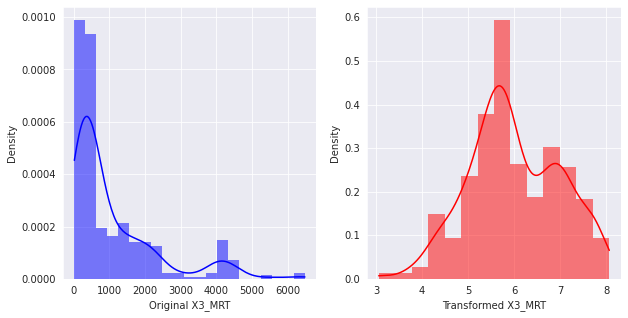

In [ ]:
# Use code above (adapted from https://github.com/datamadness/Automatic-skewness-transformation-for-Pandas-DataFrame) to correct skewness
X = skew_autotransform(X.copy(deep=True), include=['X3_MRT'],plot = True, exp = False, threshold = 1)

# Unfortunately there is a defect in the boxcos method on github and X6_Long cannot be transformed

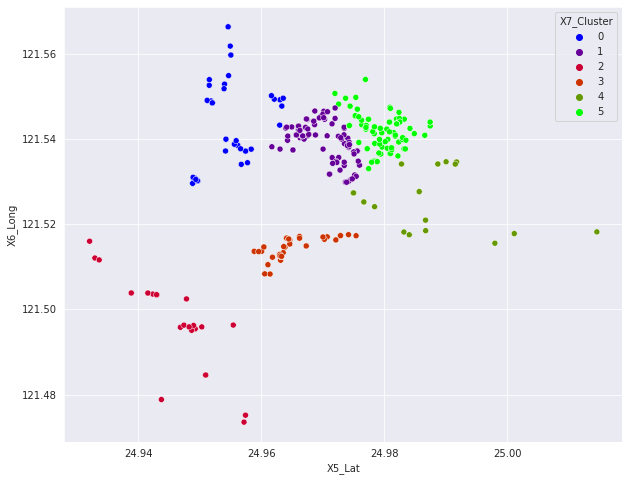

In [ ]:
# k-means clustering of latitudes & longitudes
# define the model
model = KMeans(n_clusters=6)
# fit the model
model.fit(X[['X5_Lat','X6_Long']])
# assign a cluster to each example
yhat = pd.DataFrame(model.predict(X[['X5_Lat','X6_Long']]),columns=['X7_Cluster'])
if 'X7_Cluster' not in X:
  X = pd.concat([X,yhat],axis=1)
else:
  X['X7_Cluster'] = yhat
colors = ['#747FE3', '#8EE35D', '#E37346']
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(10,8))
sns.scatterplot(x='X5_Lat', y='X6_Long', data=X, hue='X7_Cluster', palette = "brg")


In [ ]:
# Tukey Rule outliers for target (price/ping)
def tukey_rule(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_lim = data[col].quantile(0.5) + 2 * IQR
    lower_lim = data[col].quantile(0.5) - 2 * IQR
    outliers = []
    for index, x in enumerate(data[col]):
        if x < lower_lim or x >= upper_lim:
            outliers.append(index)
    return outliers

# # Identify outliers
print('OUTLIERS:\n)')
col = 'Y_Price'
outliers_Tukey = tukey_rule(y,col)
print("Column ",col,": ",outliers_Tukey)
X = X.drop(labels=outliers_Tukey, axis=0)
y = y.drop(labels=outliers_Tukey, axis=0)


OUTLIERS:
)
Column  Y_Price :  [220, 270, 312]


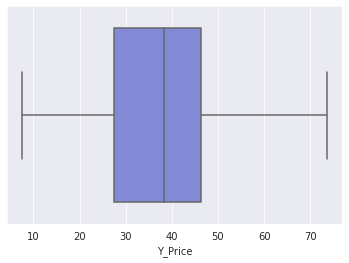

In [ ]:
# Boxplot y to check outliers
sns.boxplot(x=y['Y_Price'])

#**Holdout Sample & Scaling**

In [ ]:
col_names = X.columns

In [ ]:
# Create holdout sample
# Note: split before doing any trasformations on the data!!!

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.2,    # 80-20 training vs test set split
                     random_state=0)
print('Shape of X and y',X.shape, y.shape, '\nShape of training set X and y',X_train.shape, y_train.shape, '\nShape of test set X and y',X_test.shape, y_test.shape) 


Shape of X and y (411, 7) (411, 1) 
Shape of training set X and y (328, 7) (328, 1) 
Shape of test set X and y (83, 7) (83, 1)


In [ ]:
# Bringing features onto the same scale：normalization and standardization:

# Min-max scaling(Normalization) (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

# mms = MinMaxScaler()
# X_norm = mms.fit_transform(X)

# Standardization z-score  (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
# from sklearn.preprocessing import StandardScaler
stdsc1 = StandardScaler()  
X_train_std = stdsc1.fit_transform(X_train)
X_test_std = stdsc1.transform(X_test)
stdsc2 = StandardScaler()  
y_train_std = stdsc2.fit_transform(y_train)
y_test_std = stdsc2.transform(y_test)

#**Feature Importance**


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


<BarContainer object of 7 artists>

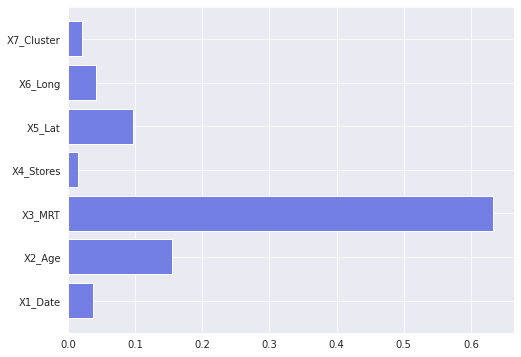

In [ ]:
# Feature Importance
# Code adapted from this source: https://machinelearningmastery.com/calculate-feature-importance-with-python/
# Let's try to weed out the really poor predictors
from matplotlib import pyplot                            # Import pyplot (to be able generate the barchart later in this snippet)
plt.rcParams["figure.figsize"] = (8,6)
model = RandomForestRegressor()                         # Create an instance of a RandomForestClassifier
# fit the model
model.fit(X_train_std, y_train_std)                  # Fit the RandomForest instance using the traiing data
# get importance 
importance = model.feature_importances_                  # The RandomForestClassifier instance computes feature importance as a bonus. Store them imprtance values in importance'.
# summarize feature importance
plt.barh(col_names, model.feature_importances_)                                              

#**Base Learner Regressors on Holdout Sample**

In [ ]:
# Report performance
def Performance(actuals,predictions):
  print('MSE: %.2f ' % mean_squared_error(actuals, predictions))
  print('MAE: %.2f ' % mean_absolute_error(actuals,predictions)) 
  print('R^2: %.2f' % r2_score(actuals, predictions))

# Plotting the actuals vs predictions 
def PredsVsActuals(actuals,predictions):
  plt.plot(actuals, predictions, '.', color='blue')
  plt.xlabel('Actuals')
  plt.ylabel('Predictions')
  plt.show()

REGRESSOR:  Multiple Linear Regression 

Coefficients: 
 [ 0.13024426 -0.18800688 -0.60497196  0.043702    0.18553444  0.05334515
  0.12747563]
MSE: 49.32 
MAE: 5.07 
R^2: 0.62


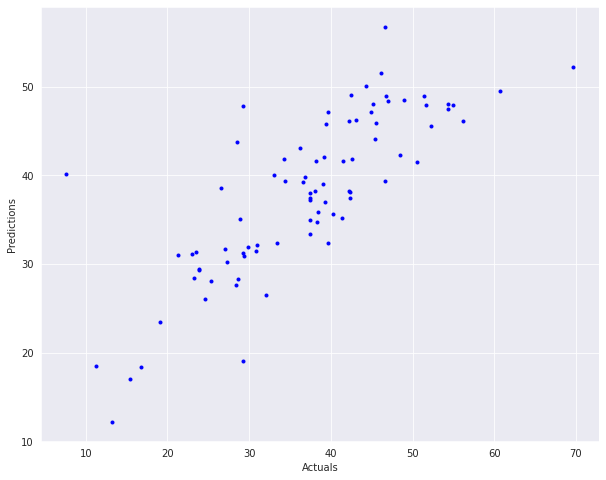

Maximum error:  428.87437477566806 %


REGRESSOR:  Lasso Regression 

Coefficients: 
 [ 0.         -0.         -0.27482671  0.          0.          0.
  0.        ]
MSE: 93.07 
MAE: 7.07 
R^2: 0.29


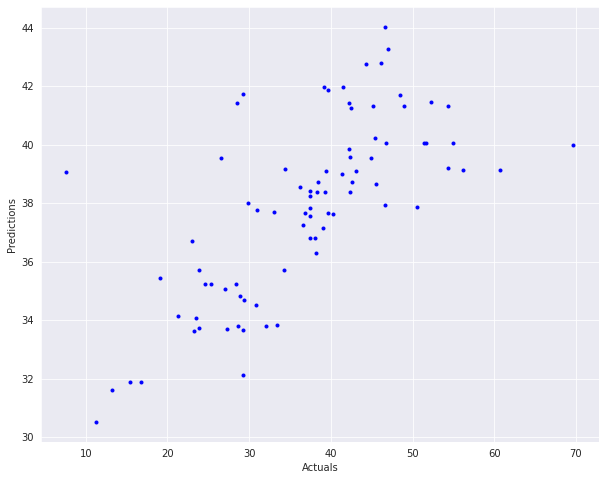

Maximum error:  414.1358542209545 %


REGRESSOR:  Ridge Regression 

Coefficients: 
 [ 0.12988549 -0.18799185 -0.60246776  0.04517711  0.18574215  0.05409526
  0.1269222 ]
MSE: 49.30 
MAE: 5.06 
R^2: 0.62


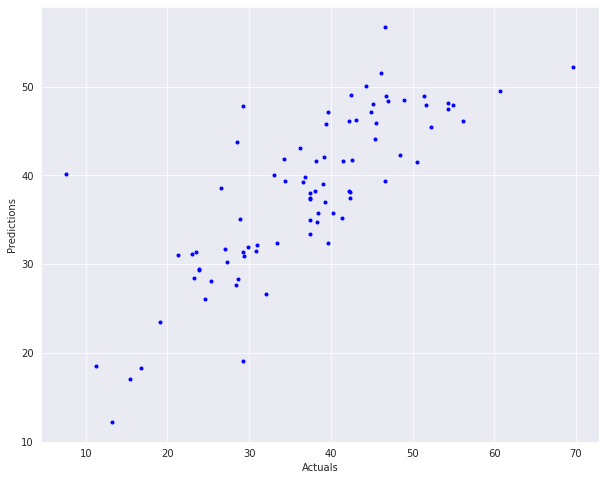

Maximum error:  428.94048126025314 %


REGRESSOR:  ElasticNet Regression 

Coefficients: 
 [ 0.00433217 -0.08343027 -0.42888682  0.08373816  0.17215612  0.03288461
  0.02876267]
MSE: 55.97 
MAE: 5.39 
R^2: 0.57


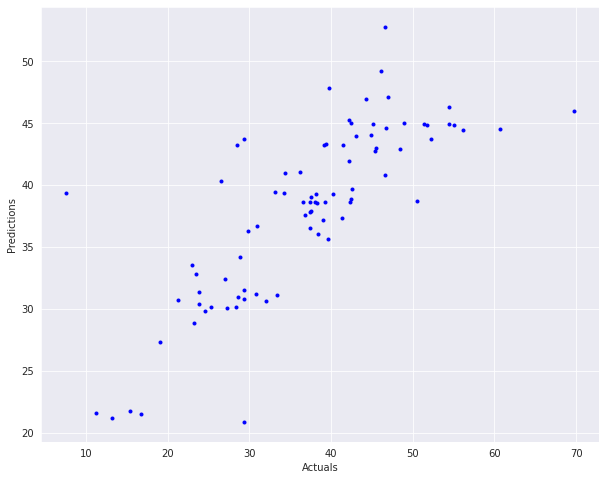

Maximum error:  418.3248763326571 %


REGRESSOR:  kNN 

MSE: 47.52 
MAE: 4.84 
R^2: 0.64


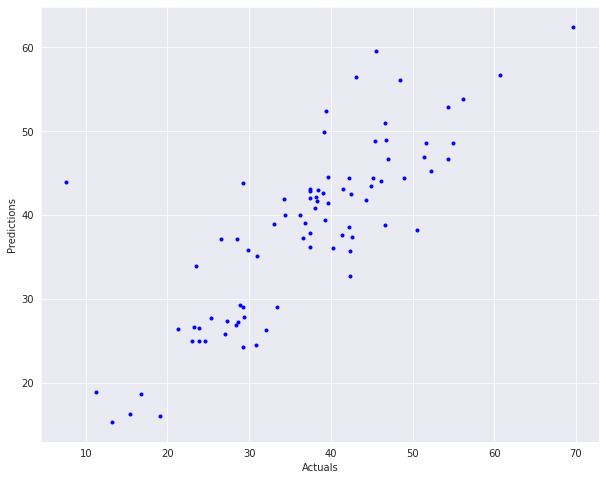

Maximum error:  478.6842105263157 %


REGRESSOR:  SVR 

MSE: 48.10 
MAE: 5.10 
R^2: 0.63


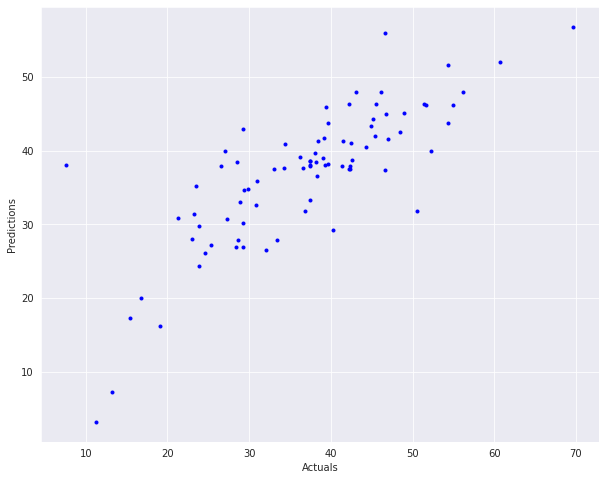

Maximum error:  400.7457741160339 %


REGRESSOR:  Decision Tree 

MSE: 67.21 
MAE: 6.02 
R^2: 0.49


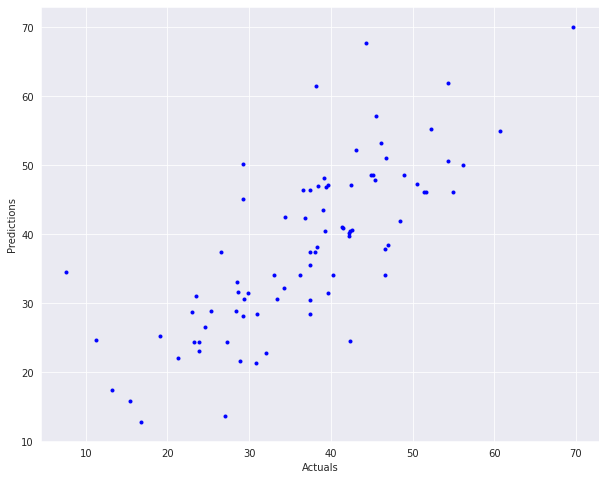

Maximum error:  355.2631578947369 %


REGRESSOR:  Multilayer Perceptron 



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MSE: 174.33 
MAE: 10.32 
R^2: -0.33


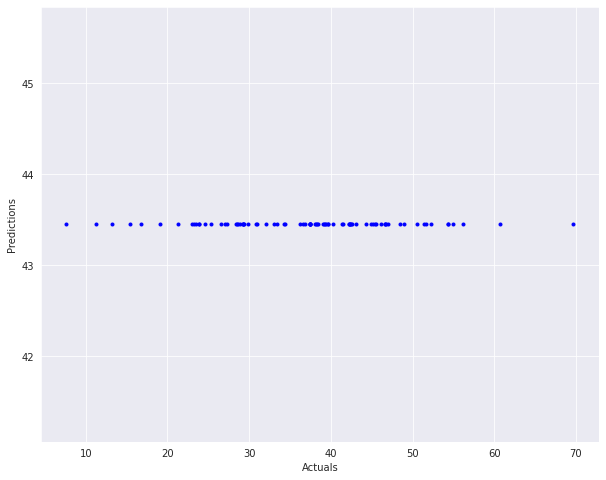

Maximum error:  471.7037091368079 %




In [ ]:
# Loop through base learners
names = ['Multiple Linear Regression', 'Lasso Regression', 'Ridge Regression','ElasticNet Regression','kNN', 'SVR','Decision Tree','Multilayer Perceptron']
regressors = [linear_model.LinearRegression(),
              Lasso(alpha=0.5),
              Ridge(alpha=0.5),
              ElasticNet(alpha=0.25, l1_ratio=0.5),
              KNeighborsRegressor(n_neighbors=5),
              SVR(kernel = 'poly'),   #Can try kernels 'poly', 'linear' and 'sigmoid' kernels
              DecisionTreeRegressor(),
              MLPRegressor(hidden_layer_sizes=(150,150,1),
                       max_iter = 300,activation = 'relu',         
                       solver = 'adam')] 

for name, regr in zip(names, regressors):
  print('REGRESSOR: ',name,'\n')
  regr.fit(X_train_std, np.ravel(y_train_std))
  # Make predictions 
  y_pred_std = regr.predict(X_test_std)
  y_pred_std = pd.DataFrame(y_pred_std)
  y_pred = stdsc2.inverse_transform(y_pred_std)
  if name in ['Multiple Linear Regression', 'Lasso Regression', 'Ridge Regression','ElasticNet Regression']:
      print('Coefficients: \n', regr.coef_)
  # Performance
  plt.figure(figsize=(10,8))
  Performance(y_test,y_pred)
  PredsVsActuals(y_test,y_pred)
  # Worst-case instance prediction
  y_pred = pd.DataFrame(y_pred) 
  results = pd.concat([y_pred, y_test.set_index(y_pred.index)], axis=1)
  results.columns=['Pred','Act']
  results['error'] = (results.Pred - results.Act)/results.Act
  print('Maximum error: ',100*np.max(results.error),'%\n\n')

#**Ensembles & Deep Learning on Holdout Sample**

In [ ]:
# Stacked Ensemble
# Code in this snippet adapted from https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

# get a stacking ensemble of models
def get_stacking():
  # define the base models
  level0 = list()
  level0.append(('MLR', linear_model.LinearRegression()))
  level0.append(('Ridge', Ridge(alpha=0.5)))
  level0.append(('RF', RandomForestRegressor()))
  level0.append(('XGB', XGBRegressor(objective ='reg:squarederror')))
  # define meta learner model
  level1 = linear_model.LinearRegression()
  # define the stacking ensemble
  model = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)
  return model
 
# get a list of models to evaluate
def get_models():
  models = dict()
  models['Multiple Linear Regression'] = linear_model.LinearRegression()
  models['Ridge Regression'] = Ridge(alpha=0.5)
  models['Random Forest'] = RandomForestRegressor()
  models['XGBoost'] = XGBRegressor(objective ='reg:squarederror')
  models['Stacked Ensemble'] = get_stacking()
  return models

In [ ]:
# Keras Deep Learning model definition
def BuildModel():
 model = Sequential()
 model.add(Dense(50, input_dim=7,activation='relu')) 
 model.add(Dense(50, activation='relu')) 
 model.add(Dense(1,activation='linear'))
 model.compile(loss="mean_squared_error", optimizer="adam")   
 return model

REGRESSOR:  Random Forest 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


MSE: 37.48 
MAE: 4.51 
R^2: 0.71


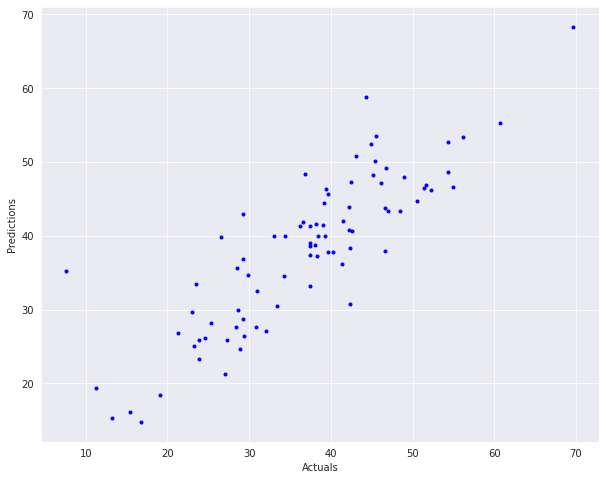

Maximum error:  363.34210526315786 %


REGRESSOR:  XGBoost 

MSE: 35.73 
MAE: 4.29 
R^2: 0.73


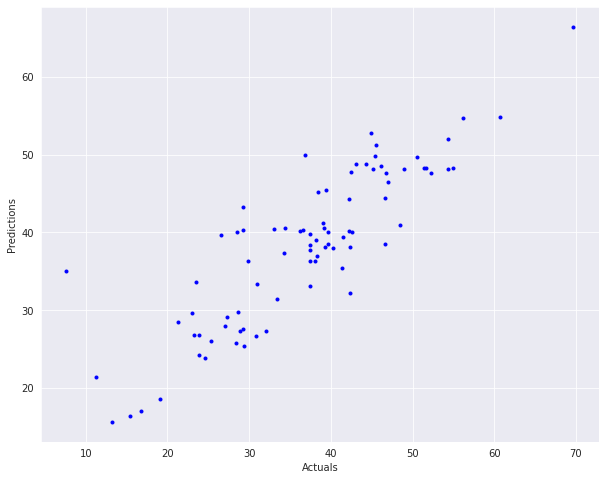

Maximum error:  361.29266839278375 %


REGRESSOR:  AdaBoost 

MSE: 46.50 
MAE: 5.10 
R^2: 0.65


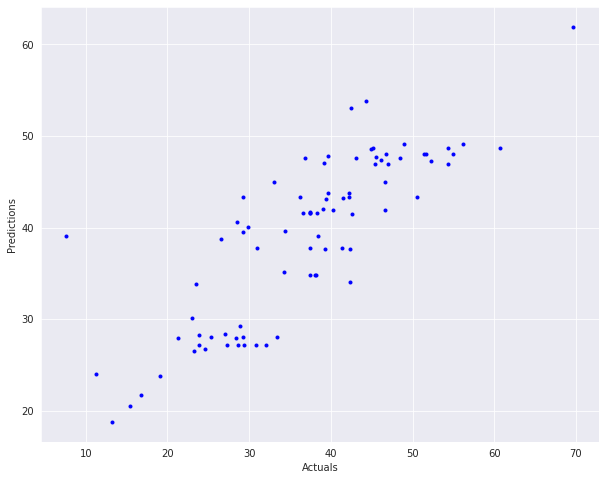

Maximum error:  413.70614035087715 %


REGRESSOR:  Keras Deep Learning 

MSE: 66.07 
MAE: 5.97 
R^2: 0.50


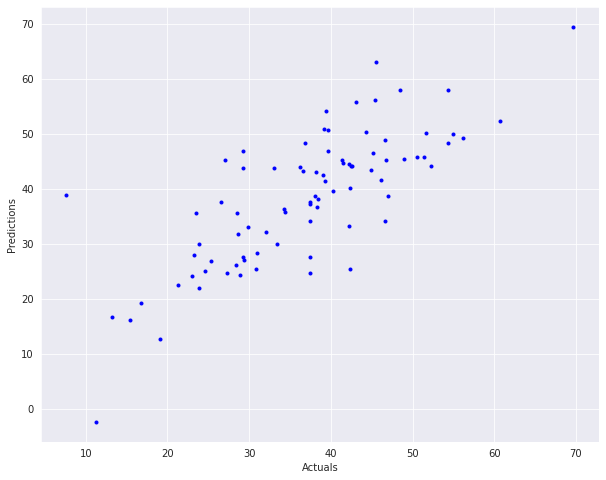

Maximum error:  412.2200313367341 %


REGRESSOR:  Stacked Ensemble 

MSE: 35.42 
MAE: 4.31 
R^2: 0.73


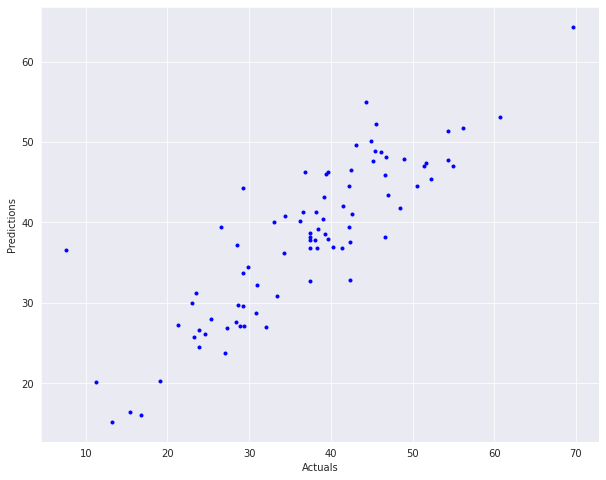

Maximum error:  381.5341255276628 %




In [ ]:
# Loop through ensembles and deep learning model
names = ['Random Forest', 'XGBoost', 'AdaBoost','Keras Deep Learning','Stacked Ensemble']
regressors = [RandomForestRegressor(),
              XGBRegressor(objective ='reg:squarederror'),
              AdaBoostRegressor(),
              KerasRegressor(build_fn=BuildModel,nb_epoch=500,epochs=500, batch_size=20,verbose=0),
              get_stacking()   
              ] 

for name, regr in zip(names, regressors):
  print('REGRESSOR: ',name,'\n')
  regr.fit(X_train_std, np.ravel(y_train_std))
  # Make predictions 
  y_pred_std = regr.predict(X_test_std)
  y_pred_std = pd.DataFrame(y_pred_std)
  y_pred = stdsc2.inverse_transform(y_pred_std)
  # Performance
  plt.figure(figsize=(10,8))
  Performance(y_test,y_pred)
  PredsVsActuals(y_test,y_pred)
  # Worst-case instance prediction
  y_pred = pd.DataFrame(y_pred) 
  y_test = pd.DataFrame(y_test)
  results = pd.concat([y_pred, y_test.set_index(y_pred.index)], axis=1)
  results.columns=['Pred','Act']
  results['error'] = (results.Pred - results.Act)/results.Act
  print('Maximum error: ',100*np.max(results.error),'%\n\n')

#**Learning Curves (Cross Validation)**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


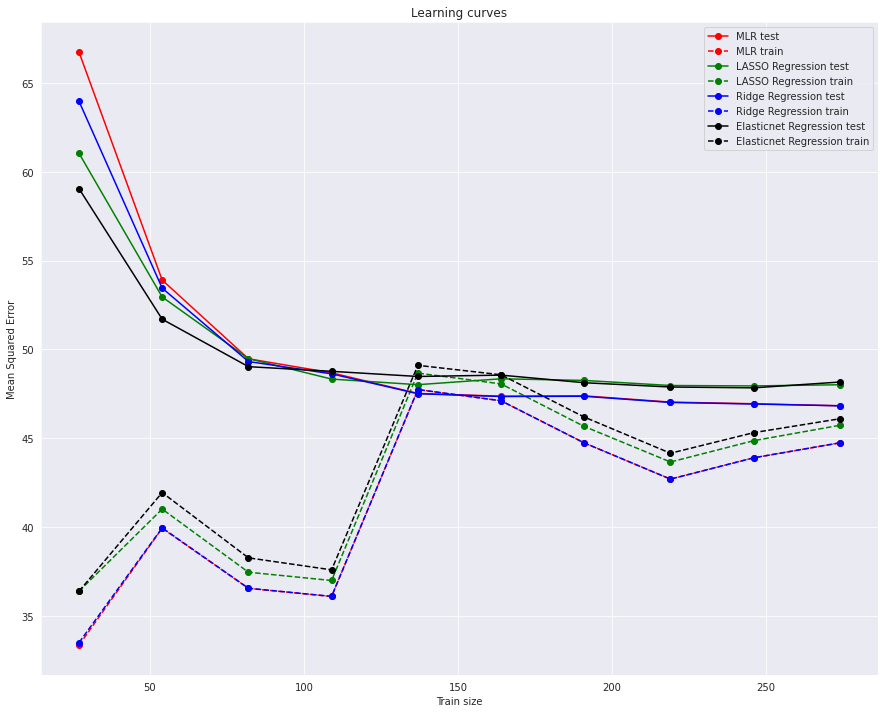

<Figure size 1600x1200 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_m

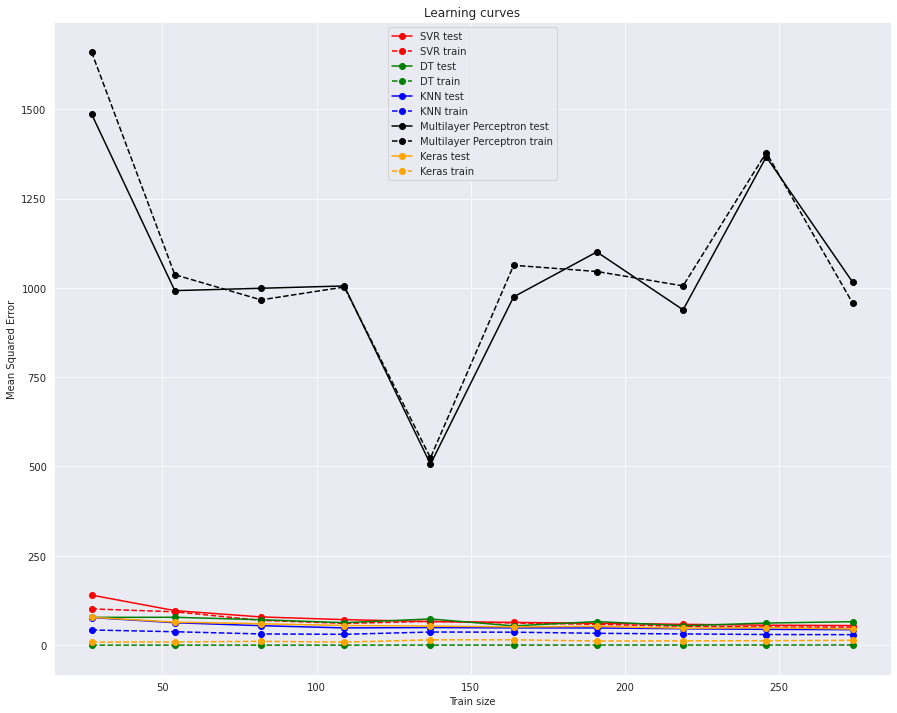

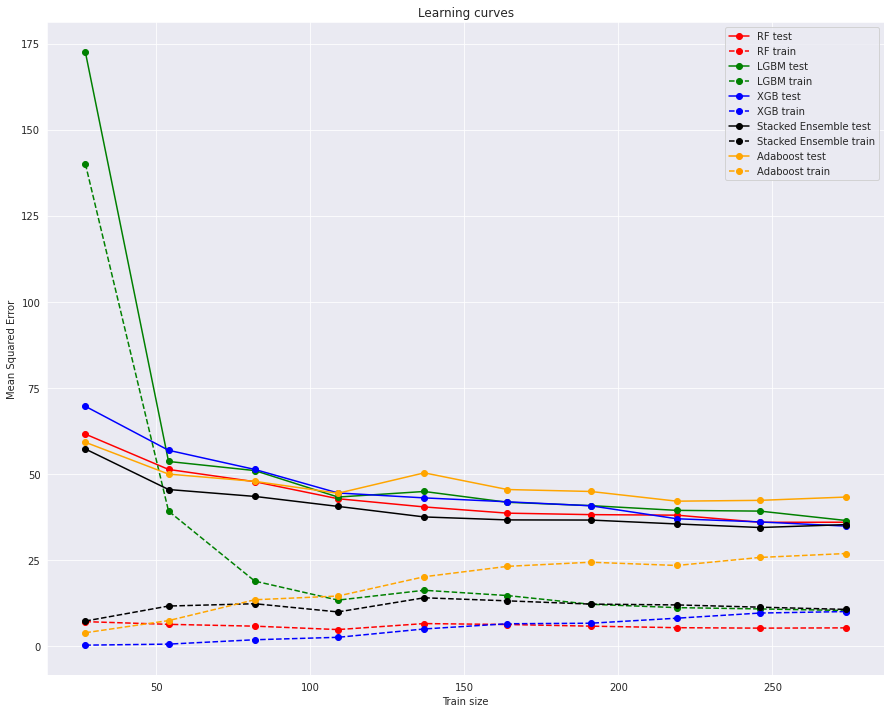

In [ ]:
from sklearn.svm import SVR
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import ShuffleSplit
from xgboost import XGBRegressor
!pip install lightgbm
from lightgbm import LGBMRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

train_size = 0.2 * len(X)

MLR = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', linear_model.LinearRegression()]])

lasso = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor',Lasso(alpha=0.5)]])

ridge = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', Ridge(alpha=0.5)]])

elasticnet = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', ElasticNet(alpha=0.25, l1_ratio=0.5)]])

MLP = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', MLPRegressor(hidden_layer_sizes=(150,150,1), max_iter = 1000,activation = 'relu', solver = 'adam')]])

kNN = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', KNeighborsRegressor(n_neighbors=5)]])

dt = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', DecisionTreeRegressor()]])

svr = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', SVR()]])

XGB = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', XGBRegressor(objective ='reg:squarederror')]])

RF = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', RandomForestRegressor()]])

LGBM = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', LGBMRegressor()]])

adaboost = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor',AdaBoostRegressor()]])

keras = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', KerasRegressor(build_fn=BuildModel,nb_epoch=500,epochs=500, batch_size=20,verbose=0)]])

stacked_ensemble = imbpipeline(steps = [['scaler', StandardScaler()],    
                                ['regressor', get_stacking()]])   


# Visualize learning curves

plt.rcParams["figure.figsize"] = (15,12)
plt.figure()

train_sizes, train_scores_MLR, test_scores_MLR = learning_curve(
    MLR,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_lasso, test_scores_lasso = learning_curve(
    lasso,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_ridge, test_scores_ridge = learning_curve(
    ridge,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_elasticnet, test_scores_elasticnet = learning_curve(
    elasticnet,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)

plt.plot(train_sizes, -test_scores_MLR.mean(1), "o-", color="r", label="MLR test")
plt.plot(train_sizes, -train_scores_MLR.mean(1), "o--", color="r", label="MLR train")
plt.plot(train_sizes, -test_scores_lasso.mean(1), "o-", color="g", label="LASSO Regression test")
plt.plot(train_sizes, -train_scores_lasso.mean(1), "o--", color="g", label="LASSO Regression train")
plt.plot(train_sizes, -test_scores_ridge.mean(1), "o-", color="blue", label="Ridge Regression test")
plt.plot(train_sizes, -train_scores_ridge.mean(1), "o--", color="blue", label="Ridge Regression train")
plt.plot(train_sizes, -test_scores_elasticnet.mean(1), "o-", color="black", label="Elasticnet Regression test")
plt.plot(train_sizes, -train_scores_elasticnet.mean(1), "o--", color="black", label="Elasticnet Regression train")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")
figure(figsize=(20, 15), dpi=80)
plt.show()

train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_dt, test_scores_dt = learning_curve(
    dt,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_kNN, test_scores_kNN = learning_curve(
    kNN,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_MLP, test_scores_MLP = learning_curve(
    MLP,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_keras, test_scores_keras = learning_curve(
    keras,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
plt.plot(train_sizes, -test_scores_svr.mean(1), "o-", color="red", label="SVR test")
plt.plot(train_sizes, -train_scores_svr.mean(1), "o--", color="red", label="SVR train")
plt.plot(train_sizes, -test_scores_dt.mean(1), "o-", color="green", label="DT test")
plt.plot(train_sizes, -train_scores_dt.mean(1), "o--", color="green", label="DT train")
plt.plot(train_sizes, -test_scores_kNN.mean(1), "o-", color="blue", label="KNN test")
plt.plot(train_sizes, -train_scores_kNN.mean(1), "o--", color="blue", label="KNN train")
plt.plot(train_sizes, -test_scores_MLP.mean(1), "o-", color="black", label="Multilayer Perceptron test")
plt.plot(train_sizes, -train_scores_MLP.mean(1), "o--", color="black", label="Multilayer Perceptron train")
plt.plot(train_sizes, -test_scores_keras.mean(1), "o-", color="orange", label="Keras test")
plt.plot(train_sizes, -train_scores_keras.mean(1), "o--", color="orange", label="Keras train")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()


train_sizes, train_scores_RF, test_scores_RF = learning_curve(
    RF,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_XGB, test_scores_XGB = learning_curve(
    XGB,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_LGBM, test_scores_LGBM = learning_curve(
    LGBM,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_adaboost, test_scores_adaboost = learning_curve(
    adaboost,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_stacked_ensemble, test_scores_stacked_ensemble = learning_curve(
    stacked_ensemble,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
plt.plot(train_sizes, -test_scores_RF.mean(1), "o-", color="red", label="RF test")
plt.plot(train_sizes, -train_scores_RF.mean(1), "o--", color="red", label="RF train")
plt.plot(train_sizes, -test_scores_LGBM.mean(1), "o-", color="green", label="LGBM test")
plt.plot(train_sizes, -train_scores_LGBM.mean(1), "o--", color="green", label="LGBM train")
plt.plot(train_sizes, -test_scores_XGB.mean(1), "o-", color="blue", label="XGB test")
plt.plot(train_sizes, -train_scores_XGB.mean(1), "o--", color="blue", label="XGB train")
plt.plot(train_sizes, -test_scores_stacked_ensemble.mean(1), "o-", color="black", label="Stacked Ensemble test")
plt.plot(train_sizes, -train_scores_stacked_ensemble.mean(1), "o--", color="black", label="Stacked Ensemble train")
plt.plot(train_sizes, -test_scores_adaboost.mean(1), "o-", color="orange", label="Adaboost test")
plt.plot(train_sizes, -train_scores_adaboost.mean(1), "o--", color="orange", label="Adaboost train")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()

#**Winner Winner, Chicken Dinner**

Base learner regressor performance results on the holdout sample are as follows:

|**Regressor** |    MSE    |       MAE      |    $R^2$    |Worst Prediction Error % |
|:----------------------|:------------:|:--------------:|:-------------:|:-------------:|
|kNN | 48.98 | 4.93 | 0.63 | 478 |
|Ridge Regression | 52.48 | 5.14 | 0.60 | 437 |
|Multiple Linear Regression (MLR) | 52.52 | 5.14 | 0.60 | 437 |
|SVM | 54.76 | 5.30 | 0.58 | 448 |
|Decision Tree | 54.78 | 5.84 | 0.71 | 167 |
|ElasticNet Regression | 57.02 | 5.40 | 0.57 | 421 |
|Multilayer Perceptron | 64.90 | 5.93 |0.51 | 355 |
|Lasso Regression | 93.07 | 7.07 |0.29 | 414 |



Ensemble and deep learner regressor performance results on the holdout sample are as follows:

|**Regressor** |    MSE    |       MAE      |    $R^2$    |  Worst Prediction Error % |
|:----------------------|:------------:|:--------------:|:-------------:|:-------------:|
|Stacked Ensemble | 34.83 | 4.27 | 0.73 | 383 |
|XGBoost | 36.16 | 4.33 | 0.72 | 359 |
|Random Forest | 37.28| 4.50 | 0.72 | 356 |
|Adaboost | 44.63 | 5.02 | 0.66 | 398 | 
|Keras DL | 72.72 | 6.17 |0.45 | 418 |



The one poor prediction generates very high worst-case instance production erors. It points to the need for better analysis of performance of the varous models using cross validation is needed before one can really pick a winner. In the interest of novelty, we will pick the Keras model and analyze its performance further.

#**Keras Model Investigated**

In [ ]:
# Cross Validation of Keras Model with Learning Curve
# Adapting code from here: https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
# This takes quite a long time to execute, even on Cola Pro
seed = 12345
np.random.seed(seed)
# define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
MSE_scores = []
Worst_cases = []
for train, test in kfold.split(X, y):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    stdsc3 = StandardScaler()  
    X_train_std = stdsc3.fit_transform(X_train)
    X_test_std = stdsc3.transform(X_test)
    stdsc4 = StandardScaler()  
    y_train_std = stdsc4.fit_transform(y_train)
    y_test_std = stdsc4.transform(y_test)
    # create model  
    model = Sequential()
    model.add(Dense(50, input_dim=7, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
    # Fit the model
    model.fit(X_train_std, np.ravel(y_train_std), epochs=500, batch_size=10, verbose=0)
    # evaluate the model
    y_pred_std = model.predict(X_test_std)
    y_pred_std = pd.DataFrame(y_pred_std)
    y_pred = stdsc4.inverse_transform(y_pred_std)
    # Performance
    mse_ = mean_squared_error(y_pred, y_test)
    MSE_scores.append(mse_)
    y_pred = pd.DataFrame(y_pred) 
    y_test = pd.DataFrame(y_test)
    results = pd.concat([y_pred, y_test.set_index(y_pred.index)], axis=1)
    results.columns=['Pred','Act']
    results['error'] = (results.Pred - results.Act)/results.Act
    error_ = 100*np.max(results.error)
    Worst_cases.append(error_)
    print('Fold: ',kfold, 'MSE: ',mse_, 'worst case instance:',error_)
print('SUMMARY:\nAverage MSE: ',np.mean(MSE_scores), 'Average worst case instance error %:',np.mean(Worst_cases))
print('SUMMARY:\nStd dev. of MSE: ',np.std(MSE_scores), 'Std dev. of worst case instance error %:',np.std(Worst_cases))

Fold:  KFold(n_splits=5, random_state=12345, shuffle=True) MSE:  45.647764961724135 worst case instance: 101.70178256192051
Fold:  KFold(n_splits=5, random_state=12345, shuffle=True) MSE:  97.21661875633808 worst case instance: 396.92786367315995
Fold:  KFold(n_splits=5, random_state=12345, shuffle=True) MSE:  52.83240777266955 worst case instance: 82.70651634703292
Fold:  KFold(n_splits=5, random_state=12345, shuffle=True) MSE:  67.34644703380195 worst case instance: 66.31601230880415
Fold:  KFold(n_splits=5, random_state=12345, shuffle=True) MSE:  47.654311400626284 worst case instance: 57.22661269338507
SUMMARY:
Average MSE:  62.139509985032 Average worst case instance error %: 140.9757575168605
SUMMARY:
Std dev. of MSE:  19.109874603035582 Std dev. of worst case instance error %: 128.86987781037874


#**Conclusion**
* A holdout sample validation approach is risky with this dataset. That said, the ensembles, and the stacked ensemble, in particular, seem to outperform the base learners. The worst case instance prediction errors are horrendous: there is one test instance that is evidently hard to predict.
* A cross-validated deep learning model yields the best performance results of the notebook, with an MSE of around 20 and a worst case error in the 115% range. 
* Overall, this solution probably does not make the cut. It's likely not suitable even as a decision aid. Additional modeling, with more instances, and more predictors (including, for example, property characteristics (beds, baths, amenities, quality of the finishes, etc.), and other neighborhood amenities)) seems to be a natural next step.
